# Laboratorio 3 - Clasificación y Regresión


En este laboratorio trabajaremos con algoritmos de clustering y reglas de asociación sobre 3 datasets:

1. __E-Commerce Data:__ Este dataset contiene transacciones realizadas por una empresa de e-commerce en distintos paises. Lo puede encontrar en el siguiente [link](https://www.kaggle.com/datasets/carrie1/ecommerce-data)
2. __Bank Customer Churn:__ Este dataset contiene información de clientes de un banco, dentro de esta base se encuentran tanto clientes fugados como no fugados. Puede encontrar el dataset en el siguiente [link](https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn)
3. __Global poverty and inequality dataset:__ Este daataset contiene información socio-demográfica proveniente del banco mundial referente a varios paises. Puede encontrar el dataset en el siguiente [link](https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv)


### Imports

In [1]:
import opendatasets as od

import pandas as pd

from matplotlib import pyplot as plt

import seaborn as sns

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import metrics

import numpy as np

import scipy
from scipy.stats import gaussian_kde

In [2]:
"""Descargamos los datasets
od.download("https://www.kaggle.com/datasets/carrie1/ecommerce-data")
od.download("https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn")
od.download("https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv")
"""

'Descargamos los datasets\nod.download("https://www.kaggle.com/datasets/carrie1/ecommerce-data")\nod.download("https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn")\nod.download("https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset?select=pip_dataset.csv")\n'

In [3]:
#Cargar csv's
bank_df = pd.read_csv("bank-customer-churn/Customer-Churn-Records.csv")

poverty_df = pd.read_csv("global-poverty-and-inequality-dataset/pip_dataset.csv")


# Preguntas

## 1. Bank Customer Churn (35 pts)
Es de interés saber qué perfil tienen los clientes que más se fugan del banco y aquellos que son más leales (menos fuga). Resuelva este problema usando modelos de clustering y posteriormente ajuste algún modelo de clasificación, validándolos según las métricas vistas en clases para ambos tipos de problemas. Discuta el desempeño por separado de ambos modelos en su respectivo problema y discuta con qué aproximación se quedaría usted para reportar los perfiles. ¿Cómo describiría usted los perfiles encontrados? (si son muchos basta discutir los que poseen mayor cantidad de elementos).



In [4]:
bank_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


### Limpieza del dataset

In [5]:
def discretizar_columna(dataframe, columname):
    lista_a_buscar = dataframe[columname].unique().tolist()
    lista = []

    for val in dataframe[columname]:
        lista.append(lista_a_buscar.index(val))
    
    dataframe["d_"+columname] = lista
    dataframe = dataframe.drop(columns = [columname])

    return dataframe

In [6]:
bank_df.columns = [i.lower().replace(' ','_') for i in bank_df.columns]
print("Tiene algun elemento vacio? : {}".format(bank_df.isnull().any().any()))

# Drop unnecessary columns
bank_df = bank_df.drop(columns = ['rownumber','customerid', "surname"])
bank_df

Tiene algun elemento vacio? : False


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,card_type,point_earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


In [7]:
# Discretizamos las columnas categóricas 
bank_df = discretizar_columna(bank_df, "geography")
bank_df = discretizar_columna(bank_df, "gender")
bank_df = discretizar_columna(bank_df, "card_type")
bank_df

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,point_earned,d_geography,d_gender,d_card_type
0,619,42,2,0.00,1,1,1,101348.88,1,1,2,464,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,3,456,1,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,3,377,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,5,350,0,0,1
4,850,43,2,125510.82,1,1,1,79084.10,0,0,5,425,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,1,300,0,1,0
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,5,771,0,1,3
9997,709,36,7,0.00,1,0,1,42085.58,1,1,3,564,0,0,2
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,2,339,2,1,1


### Modelos de clustering 

In [8]:
def data_prep(og_dataframe):
    dataframe = og_dataframe
    banks_exited_df=pd.DataFrame({'exited':dataframe['exited']})
    dataframe = dataframe.drop(columns=["exited"])

    # Scaling
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(dataframe)

    # Descomponemos el dataset en columnas representativas a traves de PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)
    
    return banks_exited_df, data_scaled, data_pca


exited_df, data_scaled, data_pca = data_prep(bank_df)

### KMeans

[0 0 3 ... 0 2 3]


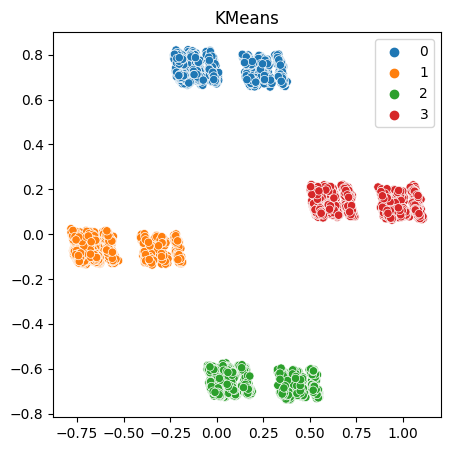

In [9]:
"""
Nombre función: KMeans_core
Parámetros:
    - num_clusters: Entero, Numero de clusters que queremos generar
    - dataframe: DataFrame a analizar
    - col1: String, nombre de la 1era columna a utilizar para el clustering.
    - col2: String, nombre de la 2da columna a utilizar para el clustering.
Tarea funcion: Genera los 'num_clusters' clusters del DataFrame 'dataframe', en base a las columnas 'col1' y 'col2'. Se separa el DataFrame en cada cluster y se almacena en la lista 'clustersDataFrames'
Retorno: Listado de Dataframes 'clustersDataFrames' y el objeto 'km' de KMeans con los parametros dados.
"""
pd.reset_option("mode.chained_assignment")

"""
Nombre funciones: print_KM
Parámetros:
    - data_pca: dataframe normalizado con MinMaxScaler() y PCA() a 2 columnas
    - model: Objeto 'km' de KMeans con los parametros dados
Tarea funcion: Grafica el scatterplot, diferenciando los clusters y sus centroides respectivos.
Retorno: Nada.
"""
def print_KM(data_pca, model):
    fig = plt.figure(figsize=(5, 5))
    ax = sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=model.labels_, palette="tab10" )
    ax.set_title("KMeans")
    plt.show()

def KMeans_core(num_clusters, data_pca, og_dataframe, name):
    dataframe = og_dataframe
    if name == "banks": dataframe = dataframe.drop(columns=["exited"])
    
    # KMEans model
    km = KMeans(n_clusters=num_clusters, n_init=10)
    model = km.fit(data_pca)
    etiquetas=km.labels_
    """
    silhouette_avg = silhouette_score(data_pca, etiquetas) !Funciona, pero tira error en el elbow al parecer cuando solo hay 1 cluster.
    print("Silhouette = ", silhouette_avg)
    """

    y_pred = model.labels_.astype(int)
    print (y_pred)
    
    dataframe["cluster"] = y_pred
    clustersDataFrames=[]
    for eachCluster in range(num_clusters):
        clustersDataFrames.append(dataframe[dataframe.cluster==eachCluster])
    return dataframe, clustersDataFrames, model, etiquetas


dataframe, clusters, km, km_labels = KMeans_core(4, data_pca, bank_df, "banks")

print_KM(data_pca, km)



In [10]:
dataframe

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,complain,satisfaction_score,point_earned,d_geography,d_gender,d_card_type,cluster
0,619,42,2,0.00,1,1,1,101348.88,1,2,464,0,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,1,3,456,1,0,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,3,377,0,0,0,3
3,699,39,1,0.00,2,0,0,93826.63,0,5,350,0,0,1,3
4,850,43,2,125510.82,1,1,1,79084.10,0,5,425,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1,300,0,1,0,2
9996,516,35,10,57369.61,1,1,1,101699.77,0,5,771,0,1,3,1
9997,709,36,7,0.00,1,0,1,42085.58,1,3,564,0,0,2,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,2,339,2,1,1,2


#### Elbow Method

Para evaluar el grado de dispersión de los datos dentro de cada grupo en función del número de clusters, probamos Elbow Method y encontramos el k óptimo.

In [11]:

"""
Nombre funciones: elbowPrinter
Parámetros:
    - k_rng: vector de largo n para probar kmeans con el metodo elbow
    - sse: array de sum of square errors para cada kmean.
Tarea funcion: grafica el elbow method.
Retorno: Nada.
"""

def elbowPrinter(k_rng, sse):
    plt.xlabel("K")
    plt.ylabel("Sum of squared error")
    plt.plot(k_rng, sse)
"""
Nombre funciones: print_elbow_KM
Parámetros:
    - array_pcas: array de dataframes normalizados con MinMaxScaler() y PCA() a 2 columnas
    - array_models: array de Objetos 'km' de KMeans con los parametros dados
Tarea funcion: Grafica un 
"""

def print_elbow_KM(array_pcas, array_models):
    fig = plt.figure(figsize=(20,20))
    for i,data_pca in enumerate(array_pcas):
        ax = fig.add_subplot(5,3,i+1)
        ax = sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=array_models[i].labels_, palette="tab10")
        ax.set_title("KMeans " +str(i+1)+" clusters")

def elbow_method(dataset, data_pca, name):
    k_rng = range(1,10)
    sse = []
    array_pca, array_km = [], []

    for k in k_rng:
        data, clusters, km, km_etiquetas =KMeans_core(k, data_pca=data_pca, og_dataframe=dataset, name=name)
        sse.append(km.inertia_)
        array_pca.append(data_pca)
        array_km.append(km)
    
    return k_rng, sse, array_pca, array_km

In [12]:
k_rng, sse, array_pca, array_km = elbow_method(bank_df, data_pca, "banks")


[0 0 0 ... 0 0 0]
[1 1 1 ... 1 0 1]
[0 0 0 ... 0 1 0]
[3 3 1 ... 3 0 1]
[1 1 2 ... 1 0 4]
[3 3 5 ... 3 1 2]
[0 0 6 ... 0 5 3]
[1 1 6 ... 1 5 3]
[5 5 4 ... 5 7 2]


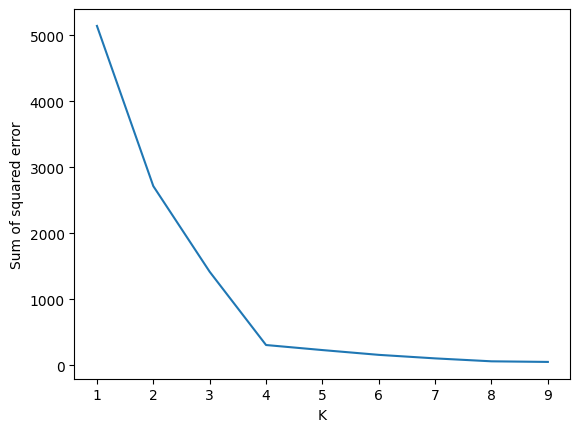

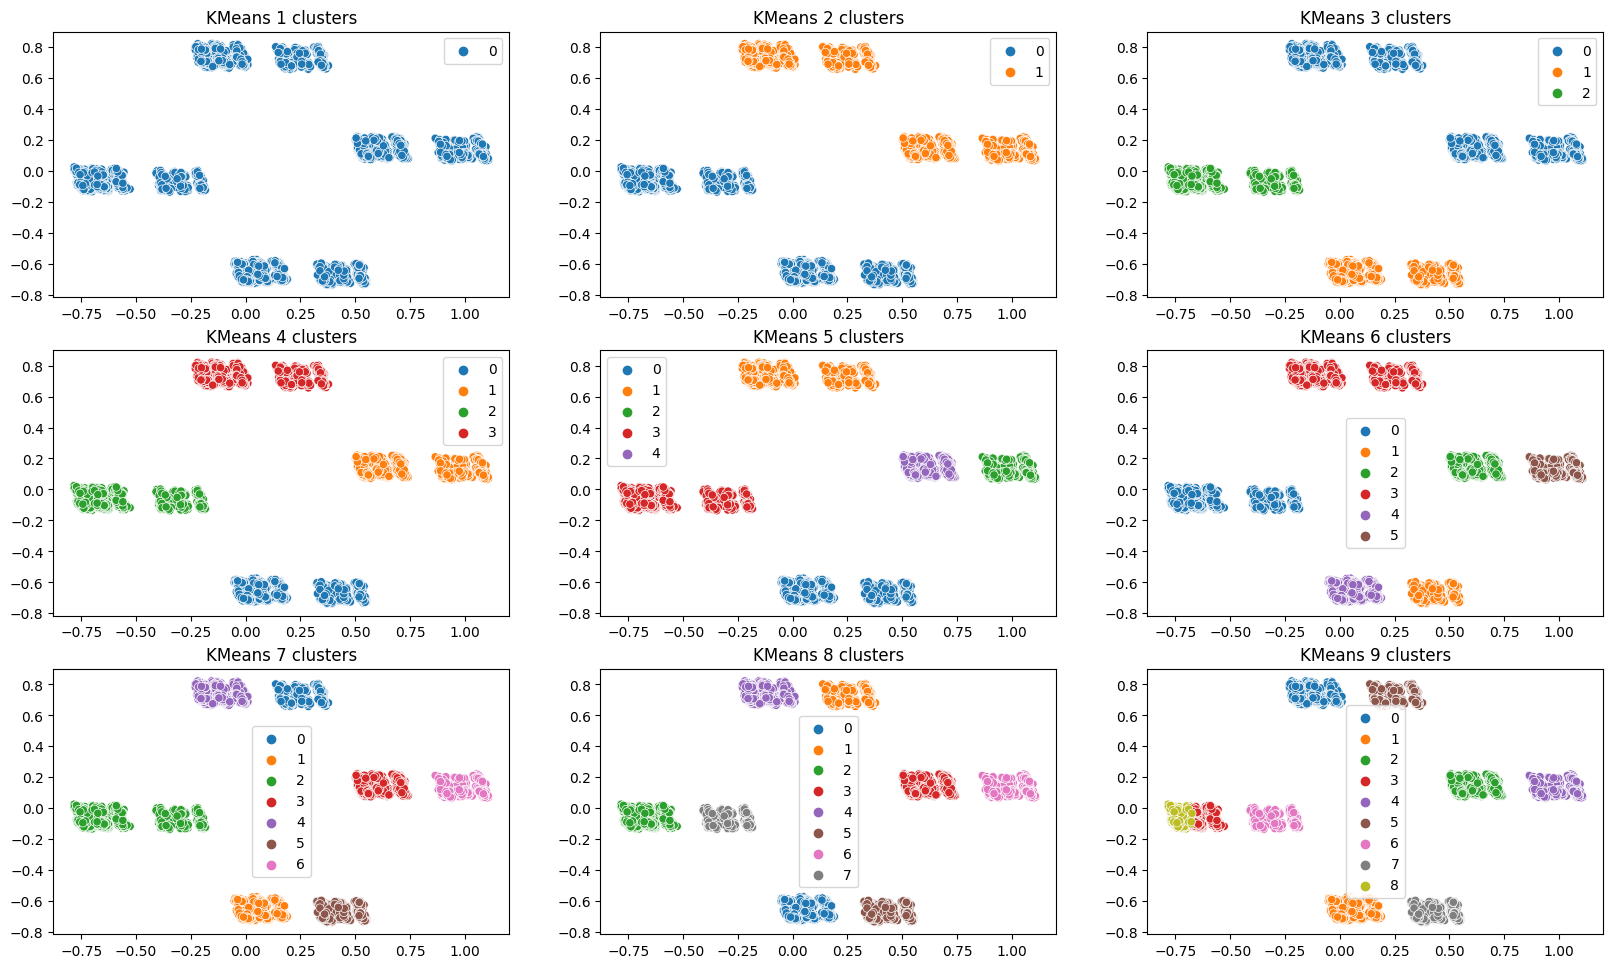

In [13]:
elbowPrinter(k_rng, sse)
print_elbow_KM(array_pca, array_km)

### DBSCAN

In [14]:

def DBSCAN_core(df_pca, og_dataframe, epsilon):
    df = og_dataframe
    df = df.drop(columns=["exited"])

    # DBSCAN Model
    model=DBSCAN(eps = epsilon, min_samples=5)
    model = model.fit(df_pca)
    etiquetas=model.labels_
    silhouette_avg = silhouette_score(df_pca, etiquetas)
    #print("Silhouette (e=", epsilon, ", MS=5)= ", silhouette_avg)

    

    y_pred = model.labels_.astype(int)
    #print(type(y_pred))
    
    df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])  #! BY: GPT Convert df_pca 
    df_pca['cluster'] = y_pred.reshape(-1,1) #!REVISAR ACA, CAMBIE A DF_PCA YA QUE ES LA CAUSA DEL ERROR QUE ESTABA SALIENDO

    #print(model)
    return model, silhouette_avg



def DBSCAN_elbow(df_pca, bank_df, min_range, max_range):
    epsilons = [round(i,2) for i in np.arange(min_range, max_range, 0.04 )]
    silSco=[]
    clusters = []
    for i in epsilons:
        #print()
        dbscan_model, silhouetteScore= DBSCAN_core(df_pca, bank_df, i)
        silSco.append(silhouetteScore)
        clusters.append(len(set(dbscan_model.labels_.tolist())))
    #print(silSco)

    return silSco, epsilons, clusters

array_silhouette, epsilons, clusters = DBSCAN_elbow(data_pca, bank_df, min_range=0.02, max_range=0.6)


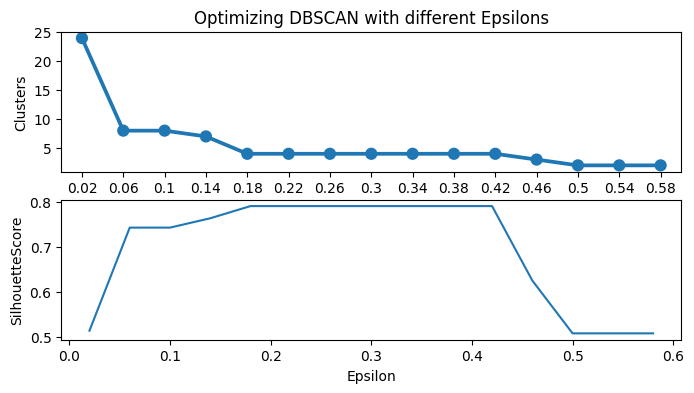

In [15]:
fig, ax = plt.subplots(2,figsize=(8,4), sharex=False)
sns.pointplot(ax = ax[0], x=epsilons, y=clusters)
sns.lineplot(ax = ax[1],x=epsilons, y=array_silhouette)#! BY: GPT
ax[0].set_title("Optimizing DBSCAN with different Epsilons")
ax[1].set_xlabel("Epsilon")
ax[0].set_ylabel("Clusters")
ax[1].set_ylabel("SilhouetteScore")
ax[0].set_xticklabels(epsilons)


plt.show()

Segun la experimentación recién hecha, los mejores resultados, basandonos en el Silhouette Score, se presentan con un $\epsilon \in [0.18, 0.42]$, en los cuales el minimo numero de clusters es 5.

In [16]:
dbscan_model, sil_avg = DBSCAN_core(data_pca, bank_df, 0.18)

### Métricas de KMeans y DBSCAN

### Comparación de resultados

Si sometemos a comparacion los metodos de clustering KMeans y DBSCAN podria ser bajo el criterio de Silhouette Score.

Silhouette score entrega una metrica, usando la razon entre:
1. $a(i)$ = La distancia media intrinseca desde el punto $i$ a su cluster $I$ ($C_I$).
    $
    \begin{equation}
        a(i)= \frac{1}{|C_{I} -1|} \cdot \sum_{i \neq j} d(i,j) \\
    \end{equation}
    $
2. $b(i)$ = La distancia media entre el punto $i$ al cluster $J$ ($C_J$) mas cercano al cluster $I$ ($C_I$).
    $
    \begin{equation}
        b(i)= min \frac{1}{|C_{J}|} \cdot \sum_{j \in C_{J}} d(i,j) \\
    \end{equation}
    $
 Luego, Silhouette Score se calcula como:
$
\begin{equation}
    Silhouette(i) = \frac{b(i)-a{i}}{max\{a(i), b(i)\}}
\end{equation}
$

Al buscar hacer un clustering lo mejor ajustado posible, buscamos que la distancia del punto, al cluster vecino sea alta, mientras que la distancia del mimso punto a los elementos de su cluster, sea baja ($b(i) >> a(i)$),  por lo anterior se entiende que **a mayor puntaje de Silhouette Score se le asigne al clustering, es porque mejor estan definidos**.

#### Resultados de Silhouette Score en KMeans y DBSCAN

In [17]:


"""
data_pca -> Data con la que se entreno KMeans
km_labels -> Etiquetas de kmeans, vienen desde dentro de la funcion core
"""
silg_kmeans= silhouette_score(data_pca, km_labels)

#* Sil_avg es silhouette, solo que se calculo dentro del core y se retorna
silh_dbscan= sil_avg

print("KMeans Silhouette: ", silg_kmeans)
print("DBSCAN Silhouette: ",silh_dbscan)



KMeans Silhouette:  0.7909055636871395
DBSCAN Silhouette:  0.7909055636871395


### SVM

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2415
           1       0.99      1.00      1.00       585

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Accuracy Score:  0.9983333333333333


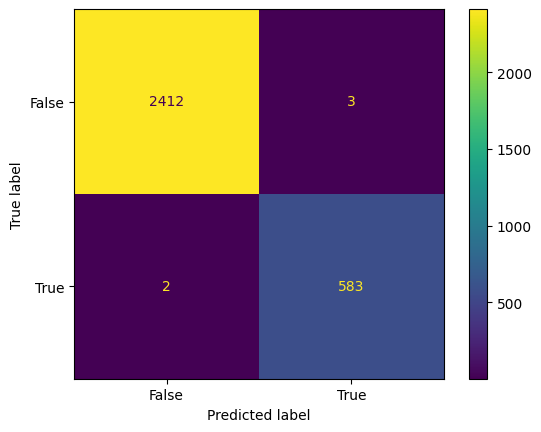

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score
from sklearn.utils.validation import column_or_1d
from numpy import ravel

x = data_scaled
y = exited_df

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=2)

## Pipeline

svc = SVC(kernel="linear")
svc.fit(X_train, Y_train.values.ravel())
y_pred = svc.predict(X_test)
print(classification_report(Y_test, y_pred))
print("Accuracy Score: " , accuracy_score(Y_test, y_pred))
confusion_matrix = confusion_matrix(Y_test, y_pred) 
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]).plot()
plt.show()


In [19]:
bank_df_c0=dataframe[dataframe.cluster==0]
bank_df_c1=dataframe[dataframe.cluster==1]
bank_df_c2=dataframe[dataframe.cluster==2]
bank_df_c3=dataframe[dataframe.cluster==3]

0       0
1       0
4       0
14      0
17      0
       ..
9950    0
9960    0
9977    0
9979    0
9997    0
Name: cluster, Length: 2284, dtype: int32

In [21]:
# Datos de las barras de cada cluster
variable="satisfaction_score"
points= [ (bank_df_c0['satisfaction_score'].value_counts())[2]+(bank_df_c0['satisfaction_score'].value_counts())[1],
         (bank_df_c1['satisfaction_score'].value_counts())[2]+(bank_df_c1['satisfaction_score'].value_counts())[1],
         (bank_df_c2['satisfaction_score'].value_counts())[2]+(bank_df_c2['satisfaction_score'].value_counts())[1],
         (bank_df_c3['satisfaction_score'].value_counts())[2]+(bank_df_c3['satisfaction_score'].value_counts())[1] ]
etiquetas=["Cluster 1","Cluster 2","Cluster 3","Cluster 4"]
x = range(len(etiquetas))


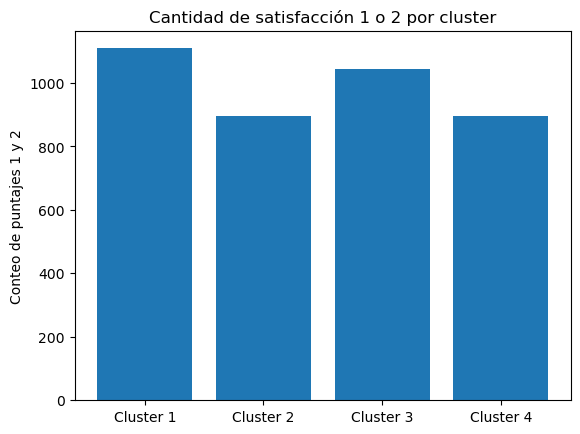

In [169]:

etiquetas = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']  # Etiquetas para cada grupo

# Crear el gráfico de barras
plt.bar(etiquetas, points)

# Personalizar el gráfico
plt.ylabel('Conteo de puntajes 1 y 2')
plt.title('Cantidad de satisfacción 1 o 2 por cluster')

# Mostrar el gráfico
plt.show()

In [174]:
contador=1
for cluster in points:
    print("Conteo en cluster",contador, cluster)
    contador+=1

Conteo en cluster 1 1109
Conteo en cluster 2 895
Conteo en cluster 3 1045
Conteo en cluster 4 897


Se noto que cada cluster tiene cantidades distintas de conteo de situaciones con puntaje de calidad de satisfacción 1 o 2, lo cual puede incidir en que un cliente abandone el banco, clasificandolos de manera descendientes en conteo de puntajes bajos de calidad de satisfacción queda:
1. Cluster 1
2. Cluster 3
3. Cluster 4
4. Cluster 2

## 2. Global Poverty and Inequality Dataset (35 pts)
Suponga que le solicitan generar una categorización de paises de acuerdo a sus características socio-demográficoas y socio-económicas en 5 grupos, aplique los métodos de clustering para clusterizar la información de los paises:


### Data Preparation

In [24]:
df = poverty_df
df.head()

,country,year,reporting_level,welfare_type,ppp_version,survey_year,survey_comparability,headcount_ratio_international_povline,headcount_ratio_lower_mid_income_povline,headcount_ratio_upper_mid_income_povline,...,decile8_thr,decile9_thr,gini,mld,polarization,palma_ratio,s80_s20_ratio,p90_p10_ratio,p90_p50_ratio,p50_p10_ratio
0,Albania,1996,national,consumption,2011,1996.0,0.0,0.920669,11.174149,44.618417,...,8.85,10.92,0.270103,0.119104,0.241293,0.928335,3.945872,3.568627,1.889273,1.888889
1,Albania,2002,national,consumption,2011,2002.0,1.0,1.570843,14.132118,49.669635,...,8.83,11.58,0.317390,0.164812,0.268982,1.215056,4.831625,3.979381,2.090253,1.903780
2,Albania,2005,national,consumption,2011,2005.0,1.0,0.860527,8.715685,38.545254,...,10.02,12.78,0.305957,0.154413,0.254529,1.142718,4.662236,3.872727,1.978328,1.957576
3,Albania,2008,national,consumption,2011,2008.0,1.0,0.313650,5.250542,31.110345,...,10.74,13.62,0.299847,0.148893,0.247311,1.114657,4.395911,3.574803,1.956897,1.826772
4,Albania,2012,national,consumption,2011,2012.0,1.0,0.849754,6.182414,34.528906,...,10.52,13.26,0.289605,0.138417,0.249988,1.041193,4.272573,3.632877,1.941435,1.871233


In [25]:
print("Tiene algun elemento vacio? : {}".format(df.isnull().any().any()))

Tiene algun elemento vacio? : True


In [26]:
## Buscar elementos vacíos y ver que hacer.
# Vamos a probar con dropear las rows con NaN

r, cols = df.shape
df = df.dropna()
print("Original shape: (", r, ",", cols, ")")
r_n, _= df.shape
print("noNaN shape: (", r_n, ",", cols, ")")
print("filas eliminadas: ", r-r_n)

Original shape: ( 4877 , 108 )
noNaN shape: ( 3643 , 108 )
filas eliminadas:  1234


In [27]:
### Buscamos las columnas categoricas para discretizar.
col_cat = df.select_dtypes('object')
col_cat = col_cat[['country','reporting_level','welfare_type']]
num_col = df.select_dtypes(['int64','float64'])   

col_cat

paises = col_cat[['country']]

df = discretizar_columna(df, "country")
df = discretizar_columna(df, "reporting_level")
df = discretizar_columna(df, "welfare_type")
df.reset_index(drop=True)


C:\Users\n3mes\AppData\Local\Temp\ipykernel_31496\604135120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["d_"+columname] = lista


,year,ppp_version,survey_year,survey_comparability,headcount_ratio_international_povline,headcount_ratio_lower_mid_income_povline,headcount_ratio_upper_mid_income_povline,headcount_ratio_100,headcount_ratio_1000,headcount_ratio_2000,...,mld,polarization,palma_ratio,s80_s20_ratio,p90_p10_ratio,p90_p50_ratio,p50_p10_ratio,d_country,d_reporting_level,d_welfare_type
0,1996,2011,1996.0,0.0,0.920669,11.174149,44.618417,0.057416,86.175208,99.632079,...,0.119104,0.241293,0.928335,3.945872,3.568627,1.889273,1.888889,0,0,0
1,2002,2011,2002.0,1.0,1.570843,14.132118,49.669635,0.046371,85.338317,98.080061,...,0.164812,0.268982,1.215056,4.831625,3.979381,2.090253,1.903780,0,0,0
2,2005,2011,2005.0,1.0,0.860527,8.715685,38.545254,0.027620,79.987127,97.576598,...,0.154413,0.254529,1.142718,4.662236,3.872727,1.978328,1.957576,0,0,0
3,2012,2011,2012.0,1.0,0.849754,6.182414,34.528906,0.111321,77.069840,97.772626,...,0.138417,0.249988,1.041193,4.272573,3.632877,1.941435,1.871233,0,0,0
4,2016,2011,2016.0,4.0,6.681604,17.621649,39.949891,2.298449,72.345234,94.700761,...,0.273740,0.350360,1.696002,8.286575,6.965217,2.376855,2.930435,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3638,2006,2017,2006.5,3.0,64.698028,81.165271,92.573347,33.916066,96.002132,99.070190,...,0.528909,0.548430,4.177633,16.776688,11.489796,3.829932,3.000000,161,0,0
3639,2010,2017,2010.0,4.0,68.456606,82.885088,93.044964,36.476496,96.299710,99.003962,...,0.539135,0.536149,4.278696,16.024650,10.470588,3.955556,2.647059,161,0,0
3640,2015,2017,2015.0,4.0,61.352160,77.548045,90.747141,34.330914,95.074710,98.777883,...,0.604667,0.613181,4.995829,21.243915,13.978261,4.095541,3.413043,161,0,0
3641,2011,2017,2011.0,0.0,21.580063,47.857143,77.945113,0.351729,88.905316,97.352365,...,0.311153,0.388356,2.207938,8.526847,6.713376,2.773684,2.420382,162,0,0


In [28]:
print(df["d_country"].unique().tolist())
print(df["d_reporting_level"].unique().tolist())
print(df["d_welfare_type"].unique().tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162]
[0, 1, 2]
[0, 1]



> ##### __2.1)__ De acuerdo a su experimentación, ¿es razonable hacer la categorización en 5 grupos para ese conjunto de datos o sugeriría una cantidad distinta?, fundamente experimentalmente su respuesta. (15 pts)
>


In [29]:
def pov_data_prep(dataframe):
    # Scaling
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(dataframe)

    # Descomponemos el dataset en columnas representativas a traves de PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)
    
    return data_scaled, data_pca

pov_scaled, pov_pca = pov_data_prep(df)

Primero, se realizó el clustering con 5 clusters, para visualizar su distribución:

[0 0 0 ... 4 3 3]
[0 4 3 2 1]


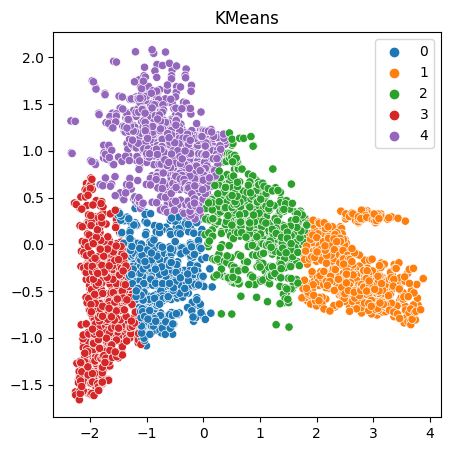

In [30]:
pov_df_5, clusters, km, etiquetas = KMeans_core(5, pov_pca, df, "pov")
print(pov_df_5.cluster.unique())
print_KM(pov_pca, km)

Luego, se calculó su Silhouette Score, para medirlo:

In [31]:
silh_kmeans= silhouette_score(pov_pca, km.labels_)
print("KMeans Silhouette: ", silh_kmeans)

KMeans Silhouette:  0.45000161738318806


### Elbow method: 

Se revisó el desempeño con distintas cantidades de clusters, basados en  Sum of Square Error (*SSE*):

In [32]:
k_rng, sse, pov_array_pca, pov_array_km = elbow_method(df, pov_pca, "pov")

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 3 0 0]
[4 4 4 ... 2 0 0]
[4 4 4 ... 3 1 1]
[2 2 2 ... 6 6 6]
[6 6 6 ... 2 2 2]
[0 0 0 ... 7 7 7]


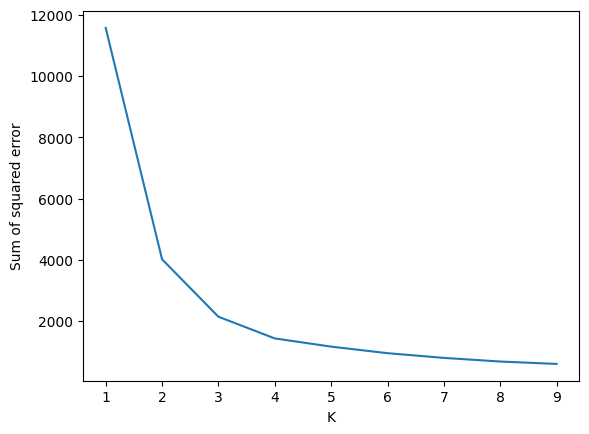

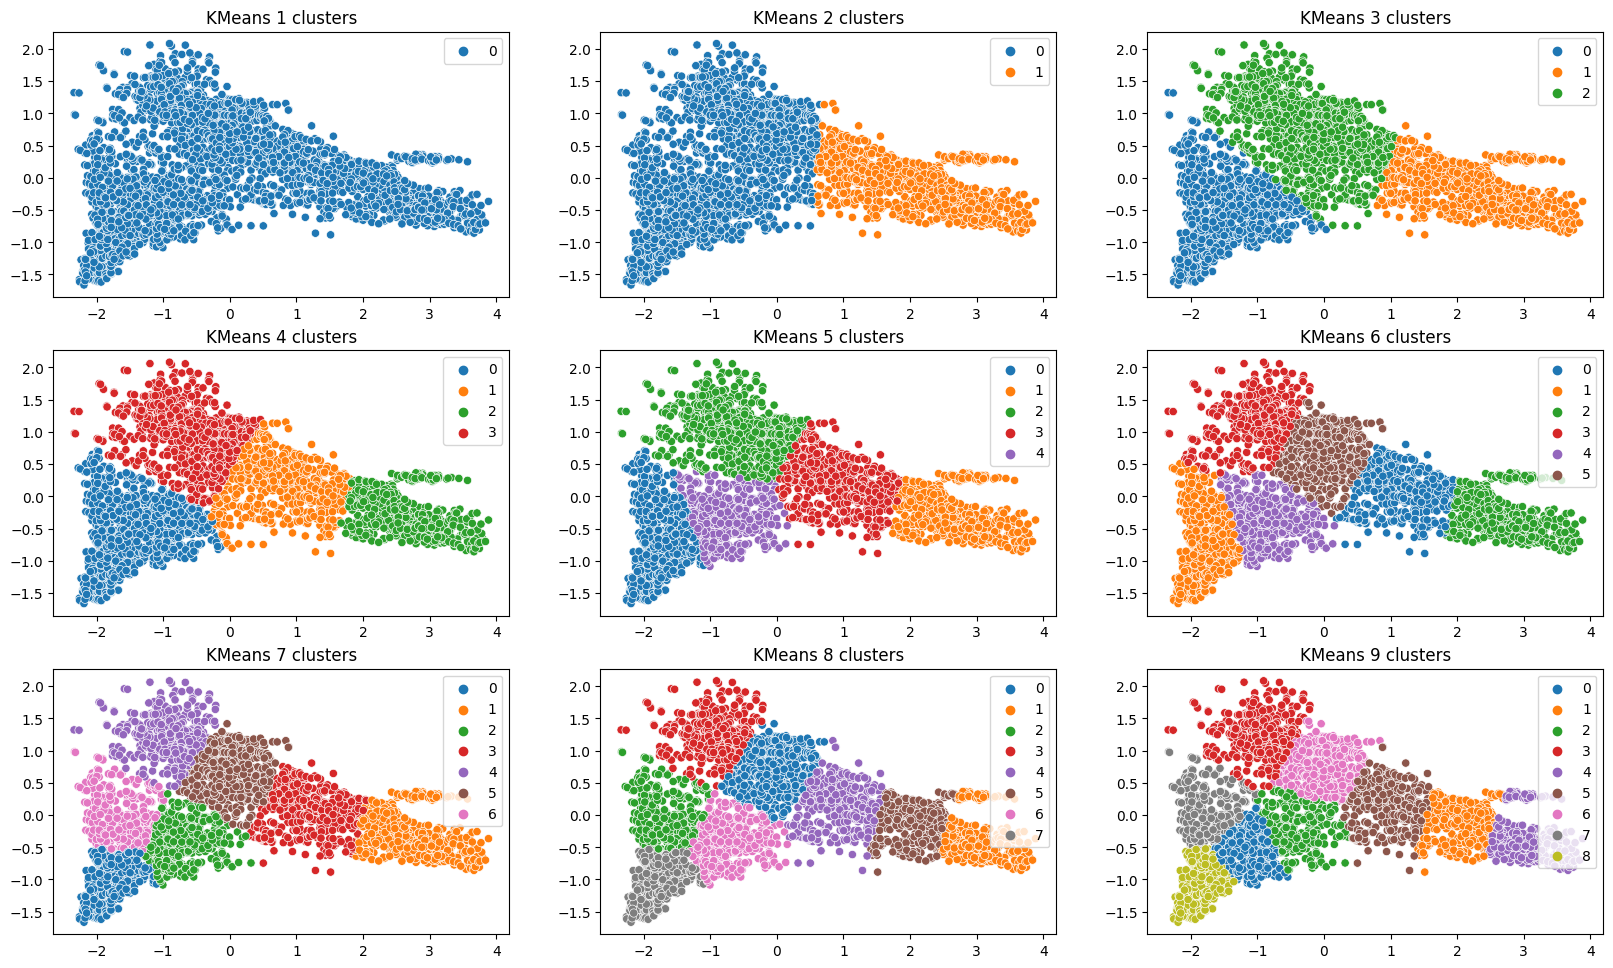

In [33]:
elbowPrinter(k_rng, sse)
print_elbow_KM(pov_array_pca, pov_array_km)

Basado en elbow method, se consideró que un mejor clustering podría ser $k=3$ o $k=4$:

[0 0 0 ... 0 0 0]
[1 1 1 ... 2 1 1]


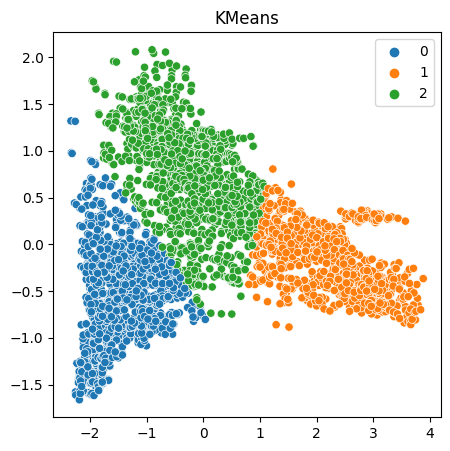

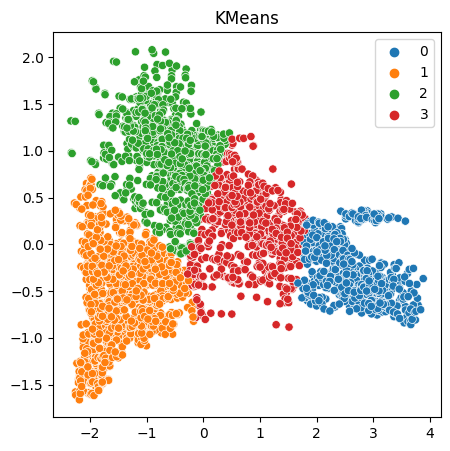

In [34]:
pov_df_3, clusters3, km3, _ = KMeans_core(3, pov_pca, df, "pov")
pov_df_4, clusters4, km4, _ = KMeans_core(4, pov_pca, df, "pov")
print_KM(pov_pca, km3)
print_KM(pov_pca, km4)

Sin embargo, para concluir cual es efectivamente el mejor clasificando, se utilizó Silhouette Score para evaluar las propuestas experimentales ($k=3$ y $k=4$) junto con la propuesta del enunciado ($k=5$), comparandolas asi bajo el mismo criterio:

In [35]:
silh_kmeans4= silhouette_score(pov_pca, km3.labels_)
silh_kmeans3= silhouette_score(pov_pca, km4.labels_)
silh_kmeans5= silhouette_score(pov_pca, km.labels_)
print("KMeans Silhouette con 3 clusters: ", silh_kmeans3)
print("KMeans Silhouette con 4 clusters: ", silh_kmeans4)
print("KMeans Silhouette con 5 clusters: ", silh_kmeans5)

## Analizar diferencias de silhouette con k=(3,4,5)

KMeans Silhouette con 3 clusters:  0.5166313891425598
KMeans Silhouette con 4 clusters:  0.5220179643215406
KMeans Silhouette con 5 clusters:  0.45000161738318806


Con base en el Silhouette Score del clustering usando KMeans con 3, 4 y 5 clusters, concluimos que estan mejor diferenciados usando **4 clusters** y no 5 como se presentó en el enunciado.

In [36]:
pov_df_4, clusters, km, etiquetas = KMeans_core(4, pov_pca, df, "pov") #Dejamos seteadas las variables, debido a que estas seran las usadas en adelante

[0 0 0 ... 2 0 0]


> ##### __2.2)__ De acuerdo a la cantidad escogida por usted en la pregunta anterior (ya sea que decidió quedarse con los 5 o una cantidad distinta) haga un análisis de los clusters explique qué características tienen los distintos grupos de paises encontrados. (10 pts)
>


In [37]:
pov_df_c0=pov_df_4[pov_df_4.cluster==0]
pov_df_c1=pov_df_4[pov_df_4.cluster==1]
pov_df_c2=pov_df_4[pov_df_4.cluster==2]
pov_df_c3=pov_df_4[pov_df_4.cluster==3]

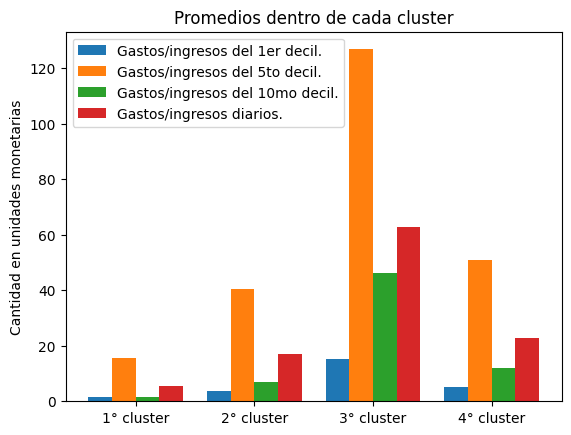

In [38]:
# Datos de las barras de cada cluster
cluster1 = [pov_df_c0['decile1_avg'].mean(), pov_df_c0['decile5_avg'].mean(), pov_df_c0['decile10_avg'].mean(),pov_df_c0['mean'].mean() ]
cluster2 = [pov_df_c1['decile1_avg'].mean(), pov_df_c1['decile5_avg'].mean(), pov_df_c1['decile10_avg'].mean(),pov_df_c1['mean'].mean() ]
cluster3 = [pov_df_c2['decile1_avg'].mean(), pov_df_c2['decile5_avg'].mean(), pov_df_c2['decile10_avg'].mean(),pov_df_c2['mean'].mean() ]
cluster4 = [pov_df_c3['decile1_avg'].mean(), pov_df_c3['decile5_avg'].mean(), pov_df_c3['decile10_avg'].mean(),pov_df_c3['mean'].mean() ]

n_clusters = 4
ancho_barras = 0.2

# Configuración de los índices de los grupos
indices = np.arange(n_clusters)
fig, ax = plt.subplots()

# Crear las barras
barra1 = ax.bar(indices, cluster1, ancho_barras, label='Gastos/ingresos del 1er decil.')
barra2 = ax.bar(indices + ancho_barras, cluster2, ancho_barras, label='Gastos/ingresos del 5to decil.')
barra3 = ax.bar(indices + 2 * ancho_barras, cluster3, ancho_barras, label='Gastos/ingresos del 10mo decil.')
barra4 = ax.bar(indices + 3 * ancho_barras, cluster4, ancho_barras, label='Gastos/ingresos diarios.')

# Configurar los ejes y las etiquetas
ax.set_ylabel('Cantidad en unidades monetarias')
ax.set_title('Promedios dentro de cada cluster')
ax.set_xticks(indices + ancho_barras * 1.5)
ax.set_xticklabels(('1° cluster', '2° cluster', '3° cluster', '4° cluster'))

ax.legend()
plt.show()

Debido a que el dataset aborda la pobreza, se quiso revisar que tal van los ingresos promedio de cada cluster, por lo que se grafico 4 grupos, uno por cada cluster, y dentro de cada cluster se revisaron las categorias mostradas en el grafico.

Como conclusion a partir del grafico, se puede extrar un orden de ingresos entre los clusters. Si se ordenan de mayor a menor quedan:
1. 3° Cluster
2. 4° CLuster
3. 2° Cluster
4. 1° Cluster

Lo cual permite extraer información rapidamente a partir de tan solo saber el cluster en el que pertenece cierto pais

### Maps

> ##### __2.3)__ Muestre en un mapa del mundo la distribución de los clusters pintando cada país con el color correspondiente al cluster al que pertenece, ¿ve algún patrón? (le será útil usar la librería `geopandas`, acá un ejemplo de como usarla: [link](https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b)) (10 pts)

__Nota:__ Cuando explore el dataset se dará cuenta que cada país no aparece solo una vez sino que varias veces de acuerdo a cada año del cuál se tiene registro, trate esta información temporal como usted estime conveniente para poder resolver el problema enunciado al principio justificando su decisión.


In [39]:
# %pip install pycountry
# %pip install geopandas
# %pip install mapclassify

In [40]:
import pycountry
import geopandas
import mapclassify


In [41]:
print(pov_df_5.cluster.unique())
df_map = pd.concat([pov_df_4["cluster"], paises["country"]], axis=1, keys=["cluster", "name"])
print(df_map.cluster.unique())

[0 2 3 1]
[0 2 3 1]


In [42]:

# Algunos paises tienen diferentes clusters... 
## Asumiremos que el correcto es el que más veces se repita

dic = {}

# Creamos un diccionario con los clusteres que aparecen en el dataset por cada pais
for index, row in df_map.iterrows():
    country = row["name"]
    cluster = row["cluster"]
    
    #Checking if country exists:
    if country in dic:
        array = dic[country]
        array.append(cluster)
        
    else:
        array = [cluster]
        dic[country] = array
    
print(dic)

f_dic = {}

for key, value in dic.items():
    most_common = max(set(value), key=value.count)  # buscamos el cluster más comun de las listas para asignarlo
    if key in f_dic:
        continue
    else:
        f_dic[key] = most_common
    
print(f_dic)
mapa = pd.DataFrame()
mapa["name"] = f_dic.keys()
mapa["cluster"] = f_dic.values()
print(mapa.cluster.unique())

{'Albania': [0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2], 'Algeria': [0, 0, 0, 0], 'Angola': [2, 0, 0, 2, 0, 2], 'Argentina': [3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'Armenia': [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Australia': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'Austria': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'Azerbaijan': [0, 0, 0, 0], 'Bangladesh': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Belarus': [3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Belgium': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'Belize

In [43]:
## Buscamos el codigo de los paises registrados

def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
mapa['CODE']=alpha3code(mapa.name)

## Paises sin codigo
print(mapa.loc[mapa["CODE"] == "None"])
print(mapa.shape)

print(mapa.cluster.unique())




                             name  cluster  CODE
14                        Bolivia        2  None
23                     Cape Verde        0  None
32                  Cote d'Ivoire        0  None
36   Democratic Republic of Congo        0  None
65                           Iran        2  None
76                         Kosovo        0  None
78                           Laos        0  None
93           Micronesia (country)        0  None
94                        Moldova        0  None
109                     Palestine        0  None
118                        Russia        3  None
131                   South Korea        1  None
139                         Syria        0  None
140                        Taiwan        1  None
142                      Tanzania        0  None
144                         Timor        0  None
158                     Venezuela        2  None
159                       Vietnam        0  None
(163, 3)
[0 3 1 2]


In [44]:
# shapefile = 'path_to_shapfile_folder/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
# gdf = geopandas.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
# gdf.columns = ['country', 'country_code', 'geometry']

# gdf.head()

In [45]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']

world = world[world.name != "Antarctica"]
print(world.shape)


(176, 6)


C:\Users\n3mes\AppData\Local\Temp\ipykernel_31496\4131371326.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


In [46]:


for index, row in mapa.iterrows():
    name = row["name"]
    if row["CODE"] == "None":
        code = world[world["name"] == name]["CODE"].values
        if len(code) > 0:
            mapa.at[index, "CODE"] = code[0]

not_found = mapa.loc[mapa["CODE"] == "None"]
not_found

,name,cluster,CODE
23,Cape Verde,0,None
32,Cote d'Ivoire,0,None
36,Democratic Republic of Congo,0,None
93,Micronesia (country),0,None
144,Timor,0,None


In [47]:
# Find where world.name == mapa.name
world[["CODE", "name"]].sort_values(by="name")
#world[world["name"]== "United States of America"]

,CODE,name
103,AFG,Afghanistan
125,ALB,Albania
82,DZA,Algeria
74,AGO,Angola
9,ARG,Argentina
...,...,...
2,ESH,W. Sahara
157,YEM,Yemen
70,ZMB,Zambia
48,ZWE,Zimbabwe


In [48]:
print(world["name"].sort_values())
print(mapa["name"].sort_values())


103    Afghanistan
125        Albania
82         Algeria
74          Angola
9        Argentina
          ...     
2        W. Sahara
157          Yemen
70          Zambia
48        Zimbabwe
73        eSwatini
Name: name, Length: 176, dtype: object
0        Albania
1        Algeria
2         Angola
3      Argentina
4        Armenia
         ...    
158    Venezuela
159      Vietnam
160        Yemen
161       Zambia
162     Zimbabwe
Name: name, Length: 163, dtype: object


In [49]:
merged = pd.merge(world, mapa, on="CODE")
merged = merged.drop(columns=["name_y"])

merged = merged.rename(columns={"name_x":"name"})
merged



,pop_est,continent,name,CODE,gdp_md_est,geometry,cluster
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0
2,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1
3,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",1
4,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",0
...,...,...,...,...,...,...,...
143,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",3
144,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",3
145,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0
146,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",2


c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  warnings.warn(


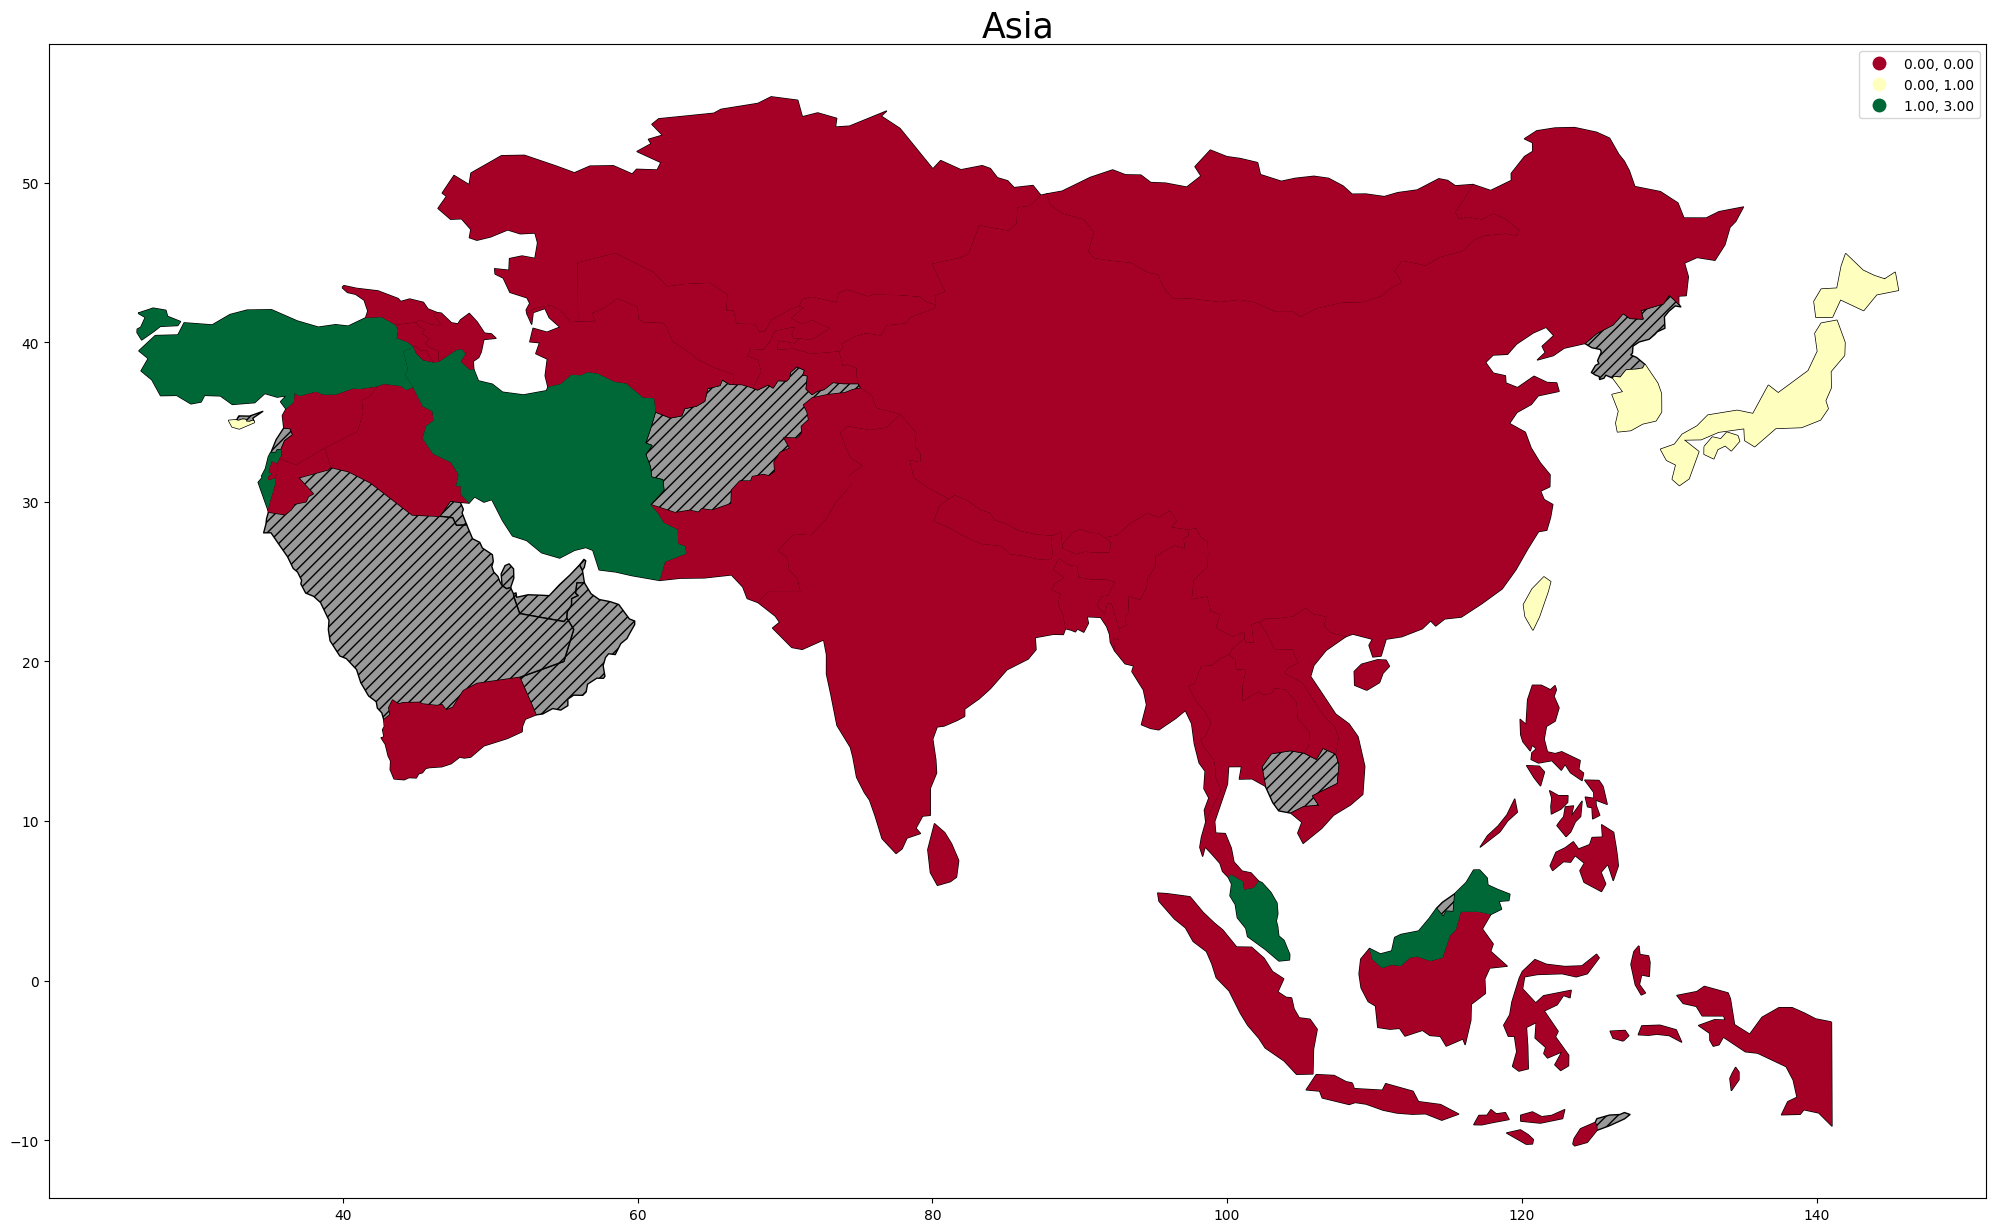

In [50]:
europa = merged[merged.continent == "Asia"]
euro = world[world.continent == "Asia"]


def print_mapa(worl, map, title, f_labels=False, plot_data="gdp_md_est", name="name"):
    fig, ax = plt.subplots(figsize=(25, 20))
    worl.plot(ax=ax, color="#999999",hatch="///", edgecolor="black", legend=True, label="Missing")
    map.plot(
        ax=ax, 
        column='cluster', 
        scheme="quantiles",
        legend=True,
        cmap='RdYlGn'
        )
    plt.title(title,fontsize=25)
    # add countries names and numbers 
    if f_labels:
        for i in range(0,len(merged)):
            plt.text(float(merged.longitude[i]),float(merged.latitude[i]),"{}\n{}".format(merged[name][i],merged[plot_data][i]),size=8)
    plt.show()
    
print_mapa(euro, europa, "Asia")

In [51]:
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
print(location["name"].values)


['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herz.'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cambodia' 'Cameroon' 'Canada' 'Central African Rep.' 'Chad' 'Chile'
 'China' 'Colombia' 'Congo' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' 'Côte d' 'Dem. Rep. Congo' 'Denmark' 'Djibouti'
 'Dominican Rep.' 'Ecuador' 'Egypt' 'El Salvador' 'Eq. Guinea' 'Eritrea'
 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'Gabon' 'Gambia' 'Georgia'
 'Germany' 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana'
 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kenya' 'Kuwait' 'Kyrgyzstan' 'Laos' 'Latvia' 'Lebanon' 'Liberia' 'Libya'
 'Lithuania' 'Luxembourg' 'Macedonia' 'Madagascar' 'Malawi' 'Malaysia'
 'Mali' 'Mauritania' 'Mexico' 'Moldo

In [52]:
merged=merged.merge(location,on='name').sort_values(by="cluster").reset_index()
merged.cluster.value_counts()
merged

,index,pop_est,continent,name,CODE,gdp_md_est,geometry,cluster,latitude,longitude
0,0,8.899530e+05,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0,-16.578193,179.414413
1,72,1.366418e+09,Asia,India,IND,2868929,"POLYGON ((97.32711 28.26158, 97.40256 27.88254...",0,20.593684,78.962880
2,71,3.225167e+06,Asia,Mongolia,MNG,13996,"POLYGON ((87.75126 49.29720, 88.80557 49.47052...",0,46.862496,103.846656
3,69,9.646211e+07,Asia,Vietnam,VNM,261921,"POLYGON ((104.33433 10.48654, 105.19991 10.889...",0,14.058324,108.277199
4,67,6.962558e+07,Asia,Thailand,THA,543548,"POLYGON ((105.21878 14.27321, 104.28142 14.416...",0,15.870032,100.992541
...,...,...,...,...,...,...,...,...,...,...
132,85,3.797087e+07,Europe,Poland,POL,595858,"POLYGON ((23.48413 53.91250, 23.52754 53.47012...",3,51.919438,19.145136
133,15,1.443735e+08,Europe,Russia,RUS,1699876,"MULTIPOLYGON (((180.00000 71.51571, 180.00000 ...",3,61.524010,105.318756
134,18,3.461734e+06,South America,Uruguay,URY,56045,"POLYGON ((-57.62513 -30.21629, -56.97603 -30.1...",3,-32.522779,-55.765835
135,120,5.454073e+06,Europe,Slovakia,SVK,105079,"POLYGON ((22.55814 49.08574, 22.28084 48.82539...",3,48.669026,19.699024


c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  warnings.warn(


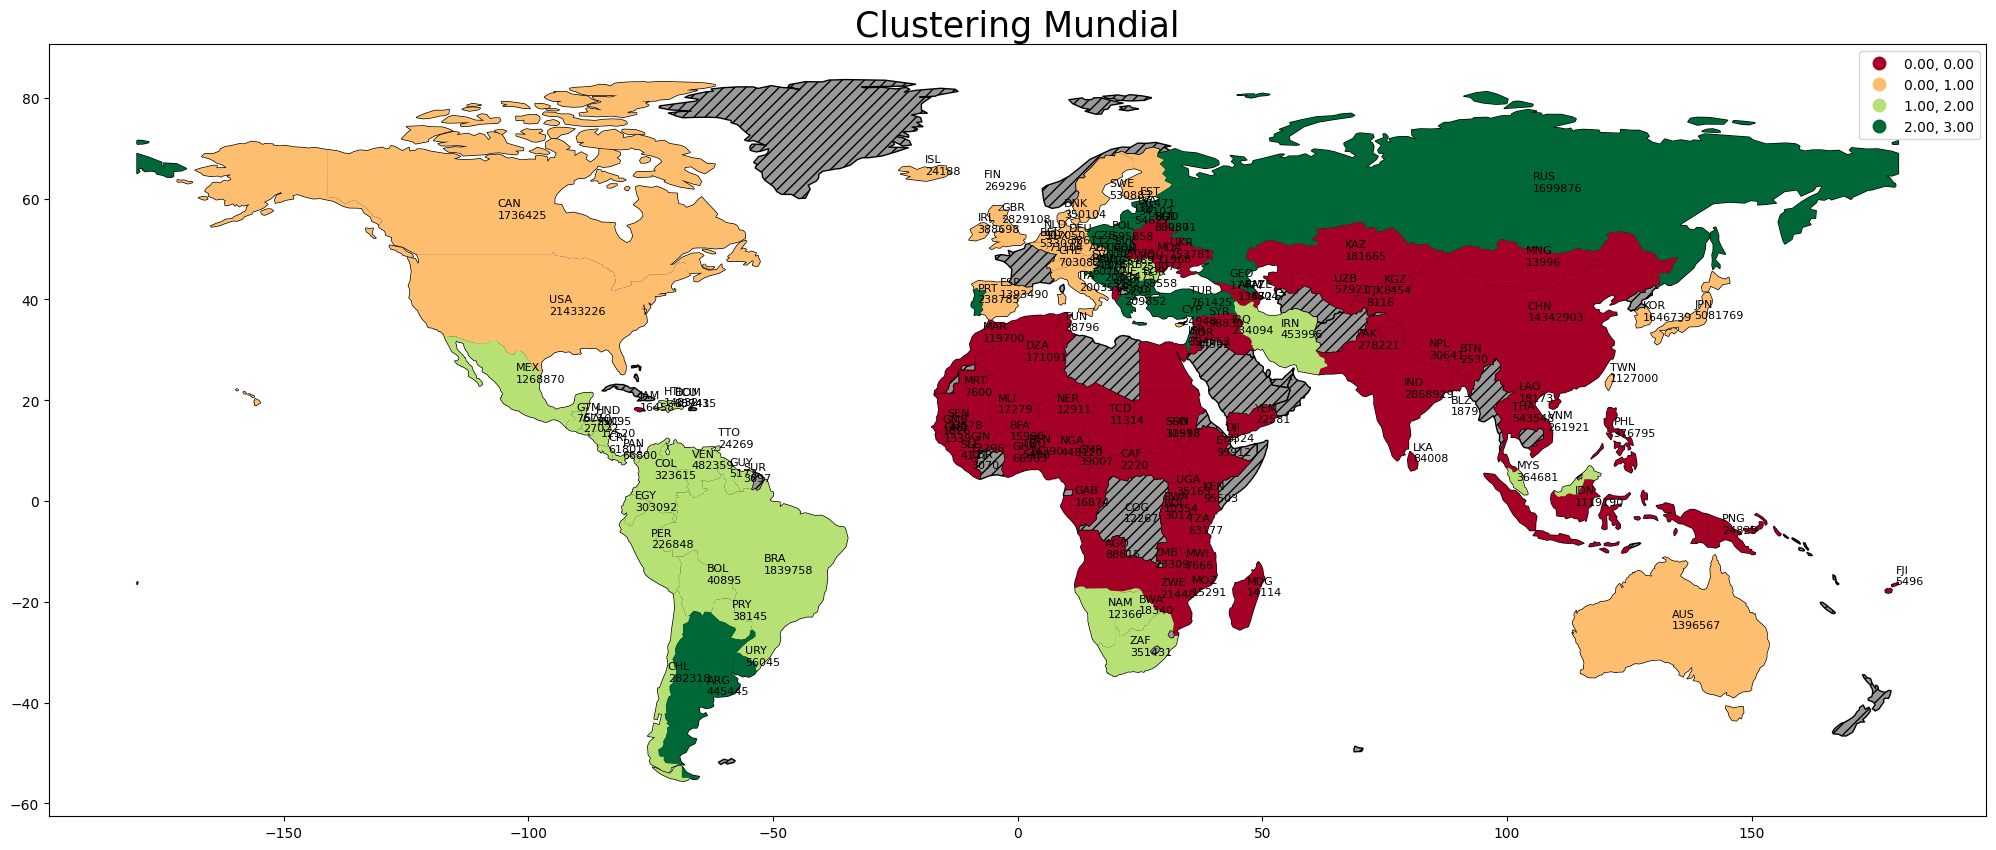

In [53]:
print_mapa(world, merged, "Clustering Mundial", True, name = "CODE", plot_data="gdp_md_est")

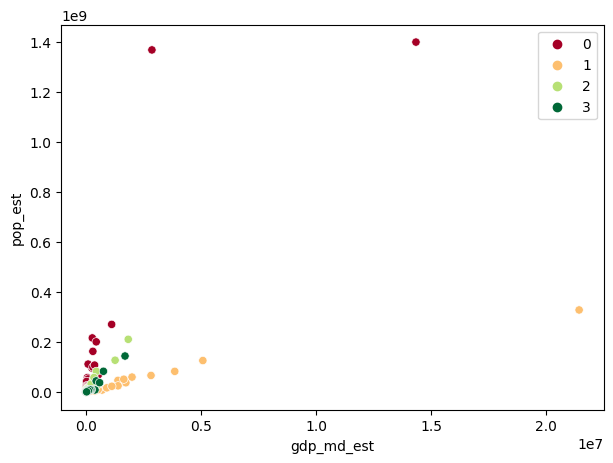

In [54]:
count = merged[["name", "cluster", "gdp_md_est", "pop_est"]]

fig, ax = plt.subplots(figsize=(7,5))
sns.scatterplot(x=count["gdp_md_est"], y=count["pop_est"], hue=count["cluster"], palette="RdYlGn")

ax.legend()
plt.show()


## 3. E-Commerce Data (30)
Aplique el algoritmo apriori (puede encontrar una buena implementación en la librería `mlxtend`) sobre el conjunto de transacciones y obtenga los 100 itemsets más significativos.


Tenga en cuenta lo siguiente:

* Cada fila es un evento de compra/devolución de un producto realizado por un cliente, para evitar trabajar con las devoluciones elimine todas aquellas filas que contengan valores negativos de `Quantity` y `UnitPrice`.
* En el método apriori de `mlxtend` se pide que las transacciones sean procesadas con un transformador llamado `TransactionEncoder` el cual requiere que los conjuntos de articulos comprados en en una misma transaccion se presenten como una lista de productos, acá hay un ejemplo de dos transacciones en el formato requerido:
```
[['pan', 'mantequilla', 'mermelada'],
['trapero', 'lavaloza', 'polera', 'pantalon', 'cereales']]
```
Para poder hacer esto necesitará "agrupar" los elementos comprados según el código de la boleta (`InvoiceNo`).
* En las transacciones realizadas hay varios errores de ingreso del código del producto y la descripción del mismo, específicamente el problema está en que hay casos donde un código de producto está ligado a más de una descripción, sin embargo, solo una de las descripciones es la correcta: La más común, acá un par de ejemplos:


In [55]:
%pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [56]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
ecom_df = pd.read_csv("ecommerce-data/data.csv", encoding= 'unicode_escape')


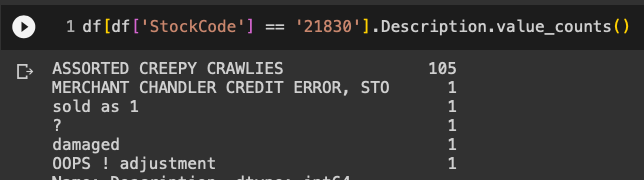




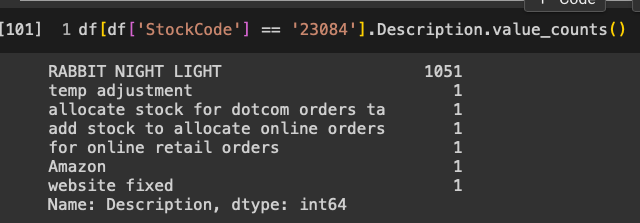

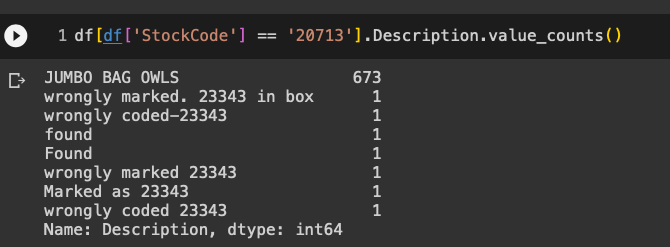

Preprocese adecuadamente las transacciones para quedarse solo con aquellas transacciones que tengan, para cada código de producto, la descripción más común encontrada para ese código. __No realizar esto implicará caer en una penalización de 15 pts.__

## Preprocesamiento 
Eliminamos los Quantity y UnitPrice <= 0

In [57]:
ecom_df = ecom_df[ecom_df['Quantity']>=0]
ecom_df = ecom_df[ecom_df["UnitPrice"] >= 0]

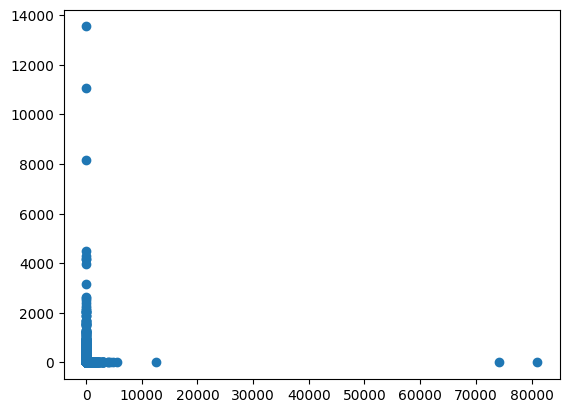

In [58]:
# Verificamos visualmente el dataset
plt.scatter(ecom_df['Quantity'], ecom_df['UnitPrice'])

In [59]:
## Buscamos duplicados
print("Duplicados:", ecom_df.duplicated().sum(), "\n")

# Y valores que nos falten:
print("Missing Values: \n",ecom_df.isna().sum())

Duplicados: 5231 

Missing Values: 
 InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133359
Country             0
dtype: int64


In [60]:
def limpiar_data(df):
    df = df.copy()
    df = df.drop_duplicates()
    df = df.dropna()
    
    #Convertimos column types
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
    df["CustomerID"] = df["CustomerID"].astype(int).astype(str)
    
    #Esta la posibilidad de limpiar outliers tbn... podriamos verlo.
    num_cols = ['Quantity', 'UnitPrice']
    for col in num_cols:
        stats = df[col].describe()
        iqr = stats['75%'] - stats['25%']
        outlier_max = stats['75%'] + 1.5 * iqr
        df[col] = df[col][df[col] < outlier_max]
        df[col] = df[col][df[col] > 0]
    
    return df

print("Number of samples:", len(ecom_df))
ecom_df = limpiar_data(ecom_df)
print("Despues de limpiar:", len(ecom_df))

Number of samples: 531283
Despues de limpiar: 392732


### EDA

Distribución de las columnas numéricas


In [61]:
num_cols = ['Quantity', 'UnitPrice']
for col in num_cols:
    print(ecom_df[col].describe())

count    367060.000000
mean          7.092105
std           6.667546
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max          26.000000
Name: Quantity, dtype: float64
count    357996.000000
mean          2.127528
std           1.521733
min           0.001000
25%           0.850000
50%           1.650000
75%           2.950000
max           7.460000
Name: UnitPrice, dtype: float64


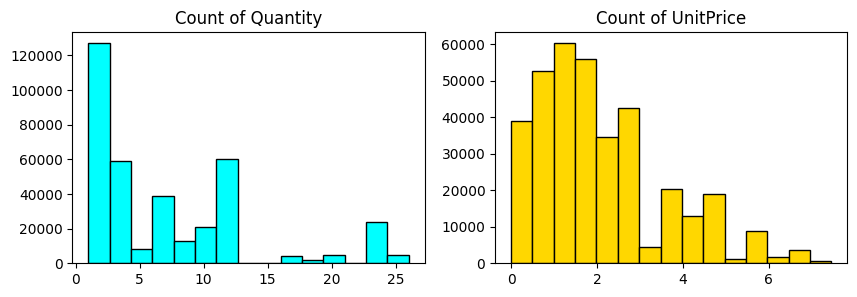

In [62]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.hist(ecom_df.Quantity, bins=15, edgecolor='black', color='cyan')
plt.title("Count of Quantity")
plt.subplot(1, 2, 2)
plt.hist(ecom_df.UnitPrice, bins=15, edgecolor='black', color='gold')
plt.title("Count of UnitPrice")
plt.show()

### Eligiendo descripciones
Preprocese adecuadamente las transacciones para quedarse solo con aquellas transacciones que tengan, para cada código de producto, la descripción más común encontrada para ese código.

In [63]:
## Limpiando eligiendo el mejor description
stock_codes = ecom_df["StockCode"].unique().tolist()
print(stock_codes)

common_descriptions = ecom_df.groupby('StockCode')['Description'].agg(lambda x: x.value_counts().index[0]).reset_index()
# Crear un nuevo DataFrame con la descripción más común por Stockcode
new_df = ecom_df.merge(common_descriptions, on=['StockCode', "Description"])

# Mostrar el nuevo DataFrame
print(ecom_df.shape)
print(new_df.shape)
new_df


['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730', '22633', '22632', '84879', '22745', '22748', '22749', '22310', '84969', '22623', '22622', '21754', '21755', '21777', '48187', '22960', '22913', '22912', '22914', '21756', '22728', '22727', '22726', '21724', '21883', '10002', '21791', '21035', '22326', '22629', '22659', '22631', '22661', '21731', '22900', '21913', '22540', '22544', '22492', 'POST', '22086', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '21258', '22114', '21733', '22386', '85099C', '21033', '20723', '84997B', '84997C', '21094', '20725', '21559', '22352', '21212', '21975', '21977', '84991', '84519A', '85183B', '85071B', '21931', '21929', '22961', '22139', '84854', '22411', '82567', '21672', '22774', '22771', '71270', '22262', '22637', '21934', '21169', '21166', '21175', '37444A', '37444C', '22083', '84971S', '47580', '22261', '84832', '22644', '21533', '21557', '15056BL', '15056N', '22646', '22176', '22438', '22778', '2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 09:02:00,2.55,17850,United Kingdom
2,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 09:32:00,2.55,17850,United Kingdom
3,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2010-12-01 10:19:00,2.55,17511,United Kingdom
4,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2010-12-01 10:39:00,2.55,13408,United Kingdom
...,...,...,...,...,...,...,...,...
387052,580691,90214W,"LETTER ""W"" BLING KEY RING",12.0,2011-12-05 15:48:00,0.29,13790,United Kingdom
387053,580691,90214Z,"LETTER ""Z"" BLING KEY RING",12.0,2011-12-05 15:48:00,0.29,13790,United Kingdom
387054,580865,90089,PINK CRYSTAL SKULL PHONE CHARM,12.0,2011-12-06 11:58:00,0.19,17914,United Kingdom
387055,581425,90089,PINK CRYSTAL SKULL PHONE CHARM,1.0,2011-12-08 15:31:00,0.19,14796,United Kingdom


#### Agrupamos el dataframe por InvoiceNo, aplicando el TransactionEncoder()

In [64]:
## Agrupamos las transacciones

transactions = new_df.groupby("InvoiceNo")["StockCode"].apply(list).tolist()

te = TransactionEncoder()
te_ary = te.fit_transform(transactions)
df_transformed = pd.DataFrame(te_ary, columns=te.columns_)

df_transformed

,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18483,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18484,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18485,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18486,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Aplicando apriori(), buscamos los 100 itemsets mas significativos

In [65]:
itemsets_freq = apriori(df_transformed, min_support=0.028, use_colnames=True)
top_itemsets = itemsets_freq.nlargest(100, "support")

top_itemsets_list = top_itemsets["itemsets"].apply(lambda x: ', '.join(list(x))).astype("unicode")
print(len(top_itemsets_list))
print(top_itemsets_list)
print()
filtered_df = new_df[new_df["StockCode"].isin(top_itemsets_list)]
filtered_df = filtered_df[["StockCode", "Description"]]
filtered_df = filtered_df.drop_duplicates(subset="StockCode")
filtered_df

100
104    85123A
42      22423
101    85099B
89      47566
97      84879
        ...  
80      23209
8       20972
98      84946
15      21485
65      22907
Name: itemsets, Length: 100, dtype: object



,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
4023,84879,ASSORTED COLOUR BIRD ORNAMENT
7069,21754,HOME BUILDING BLOCK WORD
7764,21755,LOVE BUILDING BLOCK WORD
8860,22960,JAM MAKING SET WITH JARS
...,...,...
349991,22197,POPCORN HOLDER
355079,23344,JUMBO BAG 50'S CHRISTMAS
366542,23203,JUMBO BAG VINTAGE DOILY
367170,23209,LUNCH BAG VINTAGE DOILY
